# Задача 6. Нейронные сети

- [x] Найти данные в виде изображений для задачи классификации.
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
  - FullyConnectedLayer
  - ReluLayer
  - FullyConnectedLayer
- [x]  Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] (+2 балла) Добавить Batch normalization.
- [x] (+2 балла) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] (+1 балл) Также реализовать оптимизатор Adam.

## Необходимые импорты

In [18]:
import os

import kagglehub
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

from homework.task6.utils.gradient_check import modify_fit_with_gradient_check
from homework.task6.utils.hyperparameters_search import (
    grid_search_hyperparameters,
    create_neural_network,
    visualize_hyperparameter_search,
    visualize_best_model_training,
)
from homework.task6.utils.layer import FullyConnected, ReLU, BatchNorm
from homework.task6.utils.nn import NeuralNetwork

## Загрузка датасета

[Ссылка на датасет](https://www.kaggle.com/datasets/zalando-research/fashionmnist). Содержит 60000 изображений предметов одежды в разрешении 28x28. Тренировочные и тестовые изображения и их метки описаны в соответствующих `.csv` файлах.

In [2]:
path = kagglehub.dataset_download("zalando-research/fashionmnist")
path_to_train_csv = os.path.join(path, "fashion-mnist_train.csv")
path_to_test_csv = os.path.join(path, "fashion-mnist_test.csv")

train_df = pd.read_csv(path_to_train_csv)
test_df = pd.read_csv(path_to_test_csv)

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
classes_num = len(train_df["label"].unique())
train_labels = train_df["label"].to_numpy()
train_images_normalized = train_df.drop("label", axis=1).to_numpy() / 255.0

classes_num, train_labels.shape, train_images_normalized.shape

(10, (60000,), (60000, 784))

## NeuralNetwork

### Запуск нейронной сети cо случайными параметрами

In [5]:
input_num = train_images_normalized.shape[1]
hidden_num = 128

nn = NeuralNetwork()
nn.build(
    FullyConnected(input_num, hidden_num),
    ReLU(),
    BatchNorm(hidden_num),
    FullyConnected(hidden_num, classes_num),
)

In [6]:
nn.fit(train_images_normalized, train_labels)

Epoch 0: loss = 0.9048, accuracy = 0.6972
Epoch 10: loss = 0.4321, accuracy = 0.8501
Epoch 20: loss = 0.3801, accuracy = 0.8656
Epoch 30: loss = 0.3501, accuracy = 0.8767
Epoch 40: loss = 0.3259, accuracy = 0.8854
Epoch 50: loss = 0.3066, accuracy = 0.8920
Epoch 60: loss = 0.2927, accuracy = 0.8956
Epoch 70: loss = 0.2768, accuracy = 0.9018
Epoch 80: loss = 0.2633, accuracy = 0.9070
Epoch 90: loss = 0.2545, accuracy = 0.9112


In [7]:
loss_history = nn.loss_history
accuracy_history = nn.accuracy_history

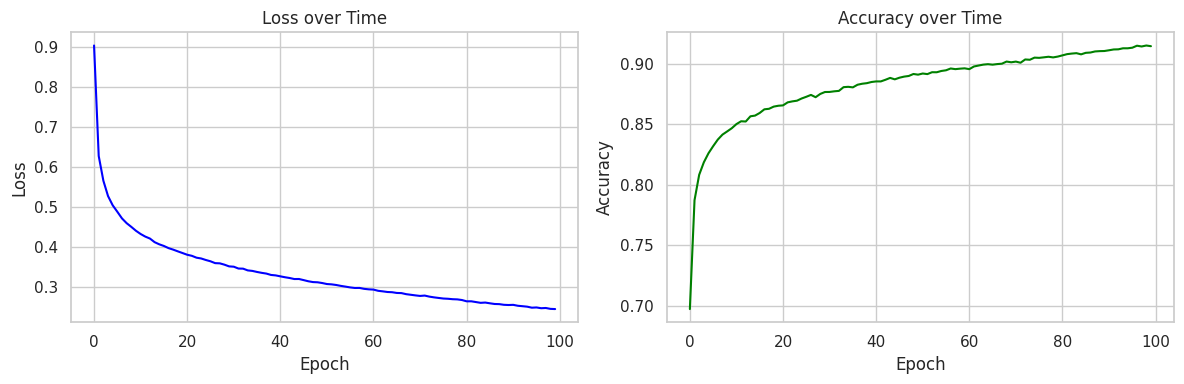

In [8]:
sns.set_theme(style="whitegrid")

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
sns.lineplot(ax=axes[0], data=loss_history, color="blue")
axes[0].set_title("Loss over Time")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Plot accuracy
sns.lineplot(ax=axes[1], data=accuracy_history, color="green")
axes[1].set_title("Accuracy over Time")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [9]:
test_labels = test_df["label"].to_numpy()
test_images_normalized = test_df.drop("label", axis=1).to_numpy() / 255.0

accuracy = accuracy_score(test_labels, nn.predict(test_images_normalized))
accuracy

0.8887

C первого запуска модель выдала хорошие результаты. В модели применялись `SGD` оптимизатор и `BatchNormalization`.

### Запуск с gradient check

In [10]:
original_fit = modify_fit_with_gradient_check(nn)
nn.fit(train_images_normalized, train_labels)


Performing gradient check at epoch 0...

===== Gradient Check Results =====

Layer: FullyConnected_0
  Parameter: W
    Max Relative Error: 2.10e-02
    Avg Relative Error: 8.25e-06
    Status: FAILED
  Parameter: b
    Max Relative Error: 1.94e-05
    Avg Relative Error: 2.74e-07
    Status: PASSED

Layer: BatchNorm_2
  Parameter: gamma
    Max Relative Error: 1.76e-06
    Avg Relative Error: 8.91e-08
    Status: PASSED
  Parameter: beta
    Max Relative Error: 1.16e-06
    Avg Relative Error: 6.55e-08
    Status: PASSED

Layer: FullyConnected_3
  Parameter: W
    Max Relative Error: 3.42e-04
    Avg Relative Error: 2.03e-06
    Status: PASSED
  Parameter: b
    Max Relative Error: 4.74e-07
    Avg Relative Error: 8.94e-08
    Status: PASSED

Overall Status: FAILED
Epoch 0: loss = 0.2424, accuracy = 0.9145
Epoch 10: loss = 0.2312, accuracy = 0.9203
Epoch 20: loss = 0.2249, accuracy = 0.9218
Epoch 30: loss = 0.2132, accuracy = 0.9251
Epoch 40: loss = 0.2050, accuracy = 0.9286
Epoch 50

Несмотря на проблему с градиентом в одном параметре, модель продолжает обучаться и улучшать свои показатели. Это может означать, что:

* Проблема с градиентом не критична для общей производительности модели
* Возможно, существует численная нестабильность в расчете градиента для весов первого полносвязного слоя

## Поиск гиперпараметров

The output is too large. Was moved to 'grid_search_dump'

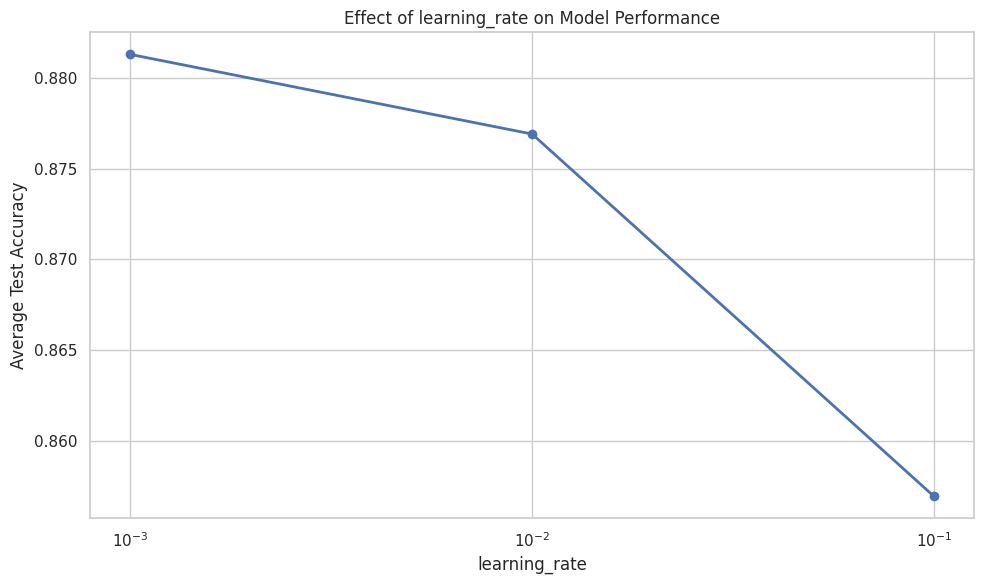

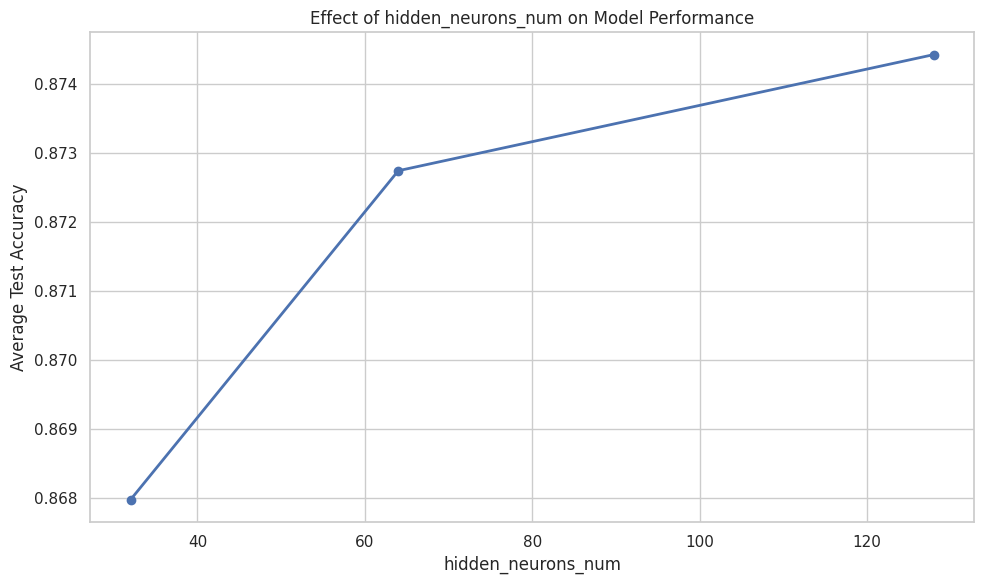

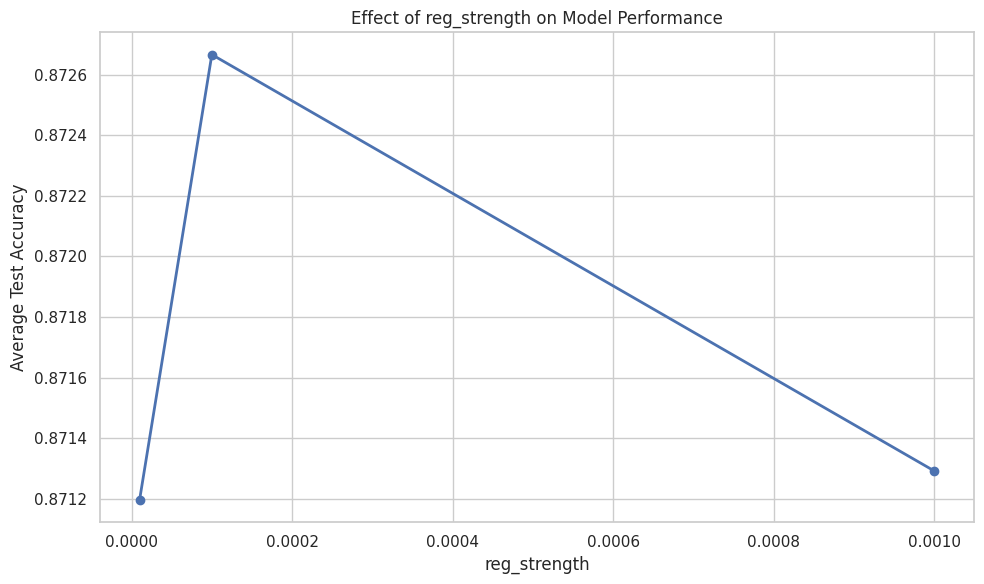

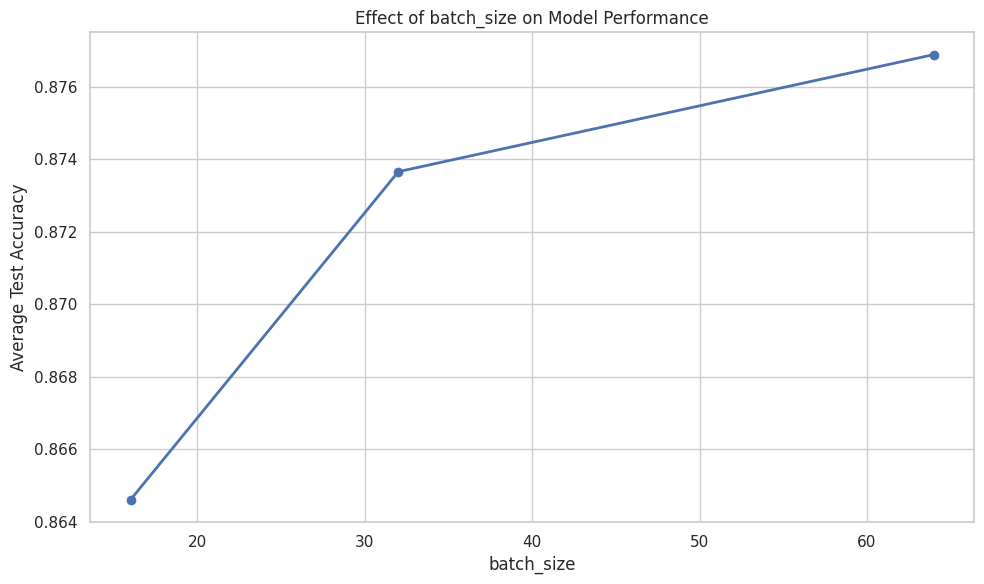

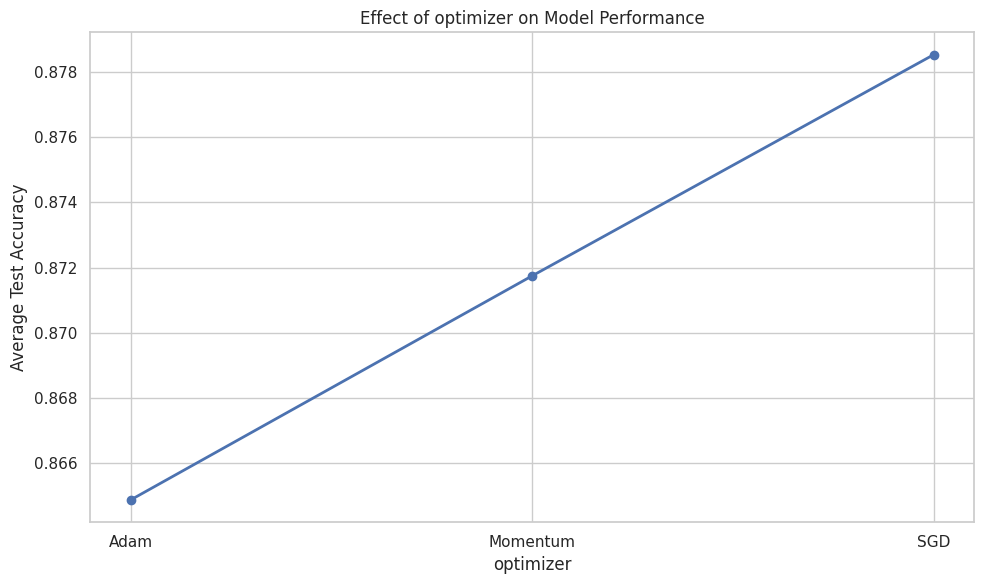

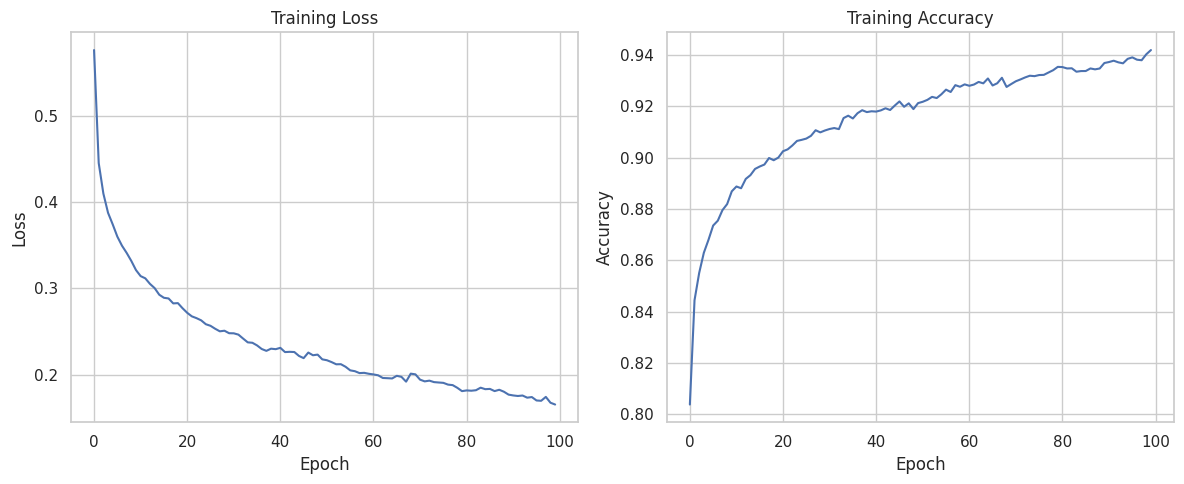

In [11]:
# Run grid search
best_params, best_model, results = grid_search_hyperparameters(
    train_images_normalized,
    train_labels,
    test_images_normalized,
    test_labels,
    classes_num=classes_num,
    nn_model_factory=create_neural_network,
)

# Visualize results
visualize_hyperparameter_search(results, "learning_rate")
visualize_hyperparameter_search(results, "hidden_neurons_num")
visualize_hyperparameter_search(results, "reg_strength")
visualize_hyperparameter_search(results, "batch_size")
visualize_hyperparameter_search(results, "optimizer")

# Visualize best model training history
visualize_best_model_training(best_model)

Подбор гиперпараметров показал, что лучшей комбинацией (опираясь на метрику точности) является набор {`learning_rate` = 0.001, `hidden_neurons_num` = 128, `reg_strength`: 1e-05, `batch_size`: 32, `epochs`: 100, `optimizer`: Momentum} (из-за слишком большого объема результата работы подбора гиперпараметров, итог был перемещен в файл `grid_search_dump`). Однако из графиков можно заметить, что в среднем лучший результат (опираясь на метрику точности) был у оптимизатора SGD и при `batch_size` = 64. Попробуем найти модель в результатах с такой комбинацией параметров.

In [20]:
results_df = pd.DataFrame(results)
presumably_better_model = results_df[
    (results_df['learning_rate'] == 1e-3) & (results_df['optimizer'] == 'SGD') & (results_df['batch_size'] == 64) & (
            results_df['hidden_neurons_num'] == 128) & (results_df['reg_strength'] == 1e-5) & (
            results_df['epochs'] == 100)]
presumably_better_model

,hidden_neurons_num,learning_rate,reg_strength,batch_size,epochs,optimizer,train_accuracy,test_accuracy,final_loss
89,128,0.001,0.00001,64,100,SGD,0.9022,0.8796,0.298049


Можно заметить, что точность такой модели на тестовых данных уступает точности нашей полученной "лучшей модели".

## Заключение
- В ходе работы была реализована нейронная сеть для классификации изображений
- В качестве датасета был использован датасет с 60000 изображений предметов одежды в разрешении 28х28
- Реализованы два полносвязных слоя (`FullyConnected`), активационный слой (`ReLU`), добавлена `Batch normalization`
- Использованы `CrossEntropyLoss` и `L2-regularization`
- Проведено обучение модели с проверкой градиентов
- Проведен подбор лучших гиперпараметров и оценка качества на тестовой части датасета
- Реализованы оптимизаторы `SGD`, `Momentum`, `Adam`
- Наиболее продвинутой оказалась модель со следующими параметрами: {`hidden_neurons_num`: 128, `learning_rate`: 0.001, `reg_strength`: 1e-05, `batch_size`: 32, `epochs`: 100, `optimizer`: Momentum}